In [35]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from vega import VegaLite
import altair as alt
import altair.vegalite.v5 as vg
import vl_convert as vlc
from IPython.display import Image
import os
import string
import random
import copy
from Levenshtein import distance as levenshtein_distance

In [36]:
def write_as_json(obj, src):
    
    json_data = json.dumps(obj)
    
    with open(src, 'w') as f:
        f.write(json_data)

In [37]:
def categorical_oversize(dataframe, index):

    for i in ['x_type','y_type']:
        if dataframe[i][index] == 'O' or dataframe[i][index] == 'N':
            return dataframe[i[0] + '_size'][index] > 30

    return False

<b> Cargo y parseo el test.sources en un pandas df </b>

In [38]:
data = []

with open('data/test.sources') as f:
    for line in f:
        
        line = line.replace('[','')
        line = line.replace(']','')
        
        data.append(json.loads(line))

write_as_json(data, 'data/test_sources.json')
df_table = pd.json_normalize(data)

In [39]:
df_table = pd.read_json("data/gpt_sources.json")

In [40]:
df_table.columns

Index(['age', 'income', 'height', 'weight', 'savings', 'temperature', 'rating',
       'experience', 'distance', 'speed', 'birth_date', 'joining_date',
       'expiry_date', 'purchase_date', 'delivery_date', 'city', 'country',
       'category', 'brand', 'product', 'education', 'employment', 'status',
       'priority', 'satisfaction', 'num_friends', 'num_followers', 'num_posts',
       'num_likes', 'num_comments', 'balance', 'credit_limit',
       'monthly_expenses', 'monthly_savings', 'num_purchases',
       'travel_distance', 'travel_time', 'shoe_size', 'shirt_size',
       'blood_pressure', 'heart_rate', 'steps_per_day', 'calories_burned',
       'sleep_hours', 'coffee_consumption'],
      dtype='object')

<b> Cargo el test.targets en un pandas df </b>

In [41]:
with open('data/balanced_targets.data') as f:
    lines = [line.rstrip('\n') for line in f]

dicts = [json.loads(i) for i in lines]
len(dicts)

1944

In [42]:
df = pd.DataFrame()

df['vega'] = lines
df['vega_dict'] = dicts
df['mark'] = [dicts[i]['mark'] for i in range(len(df))]
df['channels_count'] = [len(dicts[i]['encoding']) for i in range(len(df))]

df['x_type'] = [dicts[i]['encoding']['x']['type'] for i in range(len(df))]
df['y_type'] = [dicts[i]['encoding']['y']['type'] for i in range(len(df))]

df['x_field'] = [dicts[i]['encoding']['x']['field'] for i in range(len(df))]
df['y_field'] = [dicts[i]['encoding']['y']['field'] for i in range(len(df))]

df = df[df['mark'] != 'tick']
df = df[df['x_field'] != '*']
df = df[df['y_field'] != '*']

for type in ['x_type', 'y_type']:
    
    df.loc[(df[type] == 'quantitative'), type] = 'Q'
    df.loc[(df[type] == 'temporal'), type] = 'T'
    df.loc[(df[type] == 'ordinal'), type] = 'O'
    df.loc[(df[type] == 'nominal'), type] = 'N'

for index, row in df.iterrows():

    df_table_aux = df_table[[row['x_field'],row['y_field']]].dropna()

    count_x = len(df_table.iloc[:, df_table.columns.get_loc(row['x_field'])])
    count_y = len(df_table.iloc[:, df_table.columns.get_loc(row['y_field'])])

    #count_x = len(df_table_aux[row['x_field']].value_counts())
    #count_y = len(df_table_aux[row['y_field']].value_counts())

    length_x = len(df_table_aux[row['x_field']].values)
    length_y = len(df_table_aux[row['y_field']].values)

    df.loc[index, 'x_size'] = count_x 
    df.loc[index, 'y_size'] = count_y

    df.loc[index, 'is_function'] = count_x == length_x or count_y == length_y
    df.loc[index, 'has_aggregate'] = row['vega_dict']['encoding']['x'].get('aggregate') != None or row['vega_dict']['encoding']['y'].get('aggregate') != None
    df.loc[index, 'oversize'] = categorical_oversize(df, index)

df.loc[(df['mark'] == 'point') | (df['mark'] == 'point'), 'mark'] = 'point'
df.loc[(df['mark'] == 'area'), 'mark'] = 'line'

In [43]:
df.head(10)

,vega,vega_dict,mark,channels_count,x_type,y_type,x_field,y_field,x_size,y_size,is_function,has_aggregate,oversize
0,"{""encoding"": {""y"": {""field"": ""age"", ""type"": ""q...","{'encoding': {'y': {'field': 'age', 'type': 'q...",bar,2,Q,Q,age,age,24.0,24.0,True,False,False
1,"{""encoding"": {""y"": {""field"": ""age"", ""type"": ""q...","{'encoding': {'y': {'field': 'age', 'type': 'q...",line,2,Q,Q,age,age,24.0,24.0,True,False,False
2,"{""encoding"": {""y"": {""field"": ""age"", ""type"": ""q...","{'encoding': {'y': {'field': 'age', 'type': 'q...",point,2,Q,Q,age,age,24.0,24.0,True,False,False
3,"{""encoding"": {""y"": {""field"": ""income"", ""type"":...","{'encoding': {'y': {'field': 'income', 'type':...",bar,2,Q,Q,age,income,24.0,24.0,True,False,False
4,"{""encoding"": {""y"": {""field"": ""income"", ""type"":...","{'encoding': {'y': {'field': 'income', 'type':...",line,2,Q,Q,age,income,24.0,24.0,True,False,False
5,"{""encoding"": {""y"": {""field"": ""income"", ""type"":...","{'encoding': {'y': {'field': 'income', 'type':...",point,2,Q,Q,age,income,24.0,24.0,True,False,False
6,"{""encoding"": {""y"": {""field"": ""height"", ""type"":...","{'encoding': {'y': {'field': 'height', 'type':...",bar,2,Q,Q,age,height,24.0,24.0,True,False,False
7,"{""encoding"": {""y"": {""field"": ""height"", ""type"":...","{'encoding': {'y': {'field': 'height', 'type':...",line,2,Q,Q,age,height,24.0,24.0,True,False,False
8,"{""encoding"": {""y"": {""field"": ""height"", ""type"":...","{'encoding': {'y': {'field': 'height', 'type':...",point,2,Q,Q,age,height,24.0,24.0,True,False,False
9,"{""encoding"": {""y"": {""field"": ""weight"", ""type"":...","{'encoding': {'y': {'field': 'weight', 'type':...",bar,2,Q,Q,age,weight,24.0,24.0,True,False,False


(array([648.,   0.,   0.,   0.,   0., 648.,   0.,   0.,   0., 648.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

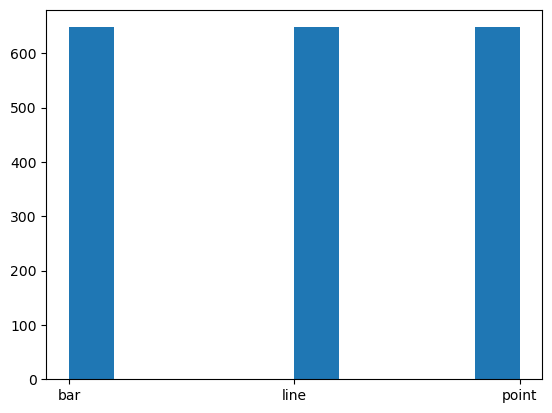

In [44]:
plt.hist(df['mark'])

In [45]:
a = [list(dicc['encoding'].keys()) for dicc in df[df['channels_count'] == 3]['vega_dict']]

flattened_list = [item for sublist in a for item in sublist]
list(set(flattened_list))

[]

<b> Aplico las reglas a las instancias de 2 variables </b>

In [46]:
df2 = df[df['channels_count'] > 1].copy()

df2['recommended_mark'] = ''
df2['swap_axis'] = False
df2['aggregate'] = False

rules = [['Q','Q','point',False],
         ['T','Q','line',   False],
         ['N','Q','bar',    False],
         ['O','Q','bar',    False],

         ['Q','T','line',   True],
         ['Q','N','bar',    False],
         ['Q','O','bar',    False]]

for rule in rules:

    df2.loc[((df2['x_type'] == rule[0]) & (df2['y_type'] == rule[1])), 'recommended_mark'] = rule[2]
    df2.loc[((df2['x_type'] == rule[0]) & (df2['y_type'] == rule[1])), 'swap_axis'] = rule[3]

df2.loc[(df2['is_function'] == False) & (df2['has_aggregate'] == False) & (df2['recommended_mark'] != 'point'), 'aggregate'] = True

In [47]:
df2.head(5)

,vega,vega_dict,mark,channels_count,x_type,y_type,x_field,y_field,x_size,y_size,is_function,has_aggregate,oversize,recommended_mark,swap_axis,aggregate
0,"{""encoding"": {""y"": {""field"": ""age"", ""type"": ""q...","{'encoding': {'y': {'field': 'age', 'type': 'q...",bar,2,Q,Q,age,age,24.0,24.0,True,False,False,point,False,False
1,"{""encoding"": {""y"": {""field"": ""age"", ""type"": ""q...","{'encoding': {'y': {'field': 'age', 'type': 'q...",line,2,Q,Q,age,age,24.0,24.0,True,False,False,point,False,False
2,"{""encoding"": {""y"": {""field"": ""age"", ""type"": ""q...","{'encoding': {'y': {'field': 'age', 'type': 'q...",point,2,Q,Q,age,age,24.0,24.0,True,False,False,point,False,False
3,"{""encoding"": {""y"": {""field"": ""income"", ""type"":...","{'encoding': {'y': {'field': 'income', 'type':...",bar,2,Q,Q,age,income,24.0,24.0,True,False,False,point,False,False
4,"{""encoding"": {""y"": {""field"": ""income"", ""type"":...","{'encoding': {'y': {'field': 'income', 'type':...",line,2,Q,Q,age,income,24.0,24.0,True,False,False,point,False,False


<b> Plot de combinaciones y mark types </b>

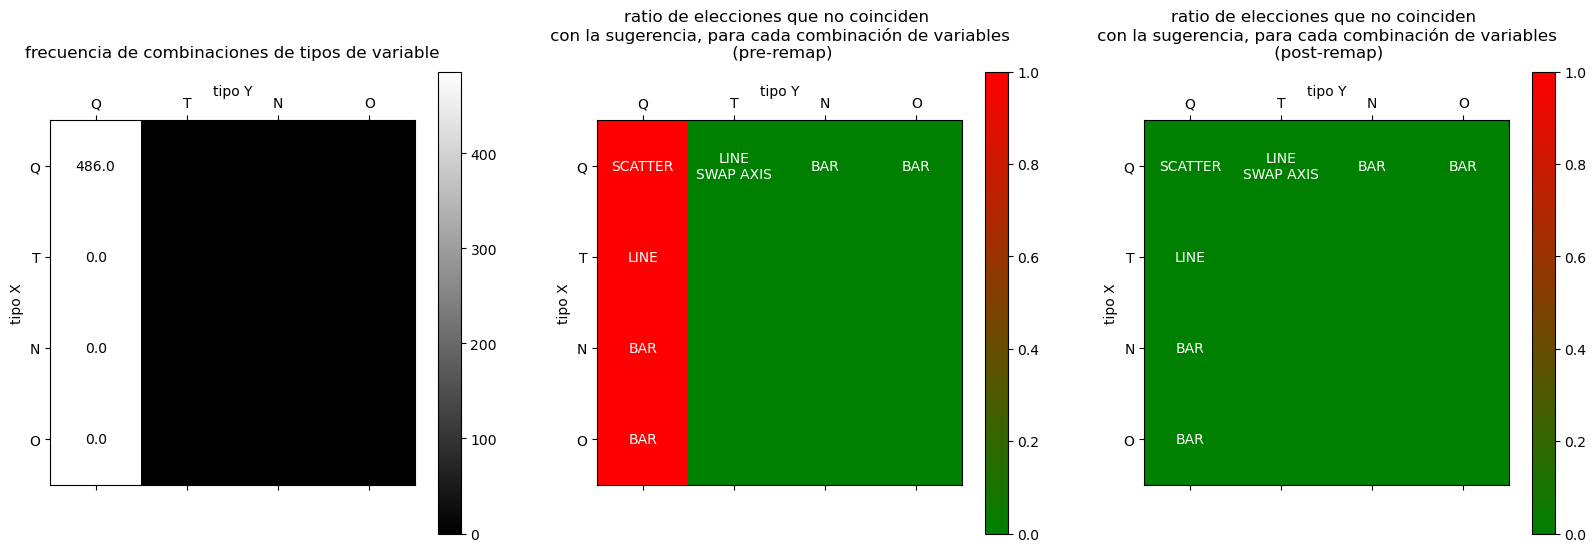

In [48]:
types = ['Q','T','N','O']
marks = [['point','line','bar','bar'],
         ['line','','',''],
         ['bar','','',''],
         ['bar','','','']]

types_mat = np.zeros((4,4))
error_mat = np.zeros((4,4))
error_mat2 = np.zeros((4,4))

for i in range(4):
    for j in range(4):
        types_mat[i][j] = df2[(df2['x_type'] == types[i]) & (df2['y_type'] == types[j])].count()[0]

for rule in rules:
        
        x = types.index(rule[0])
        y = types.index(rule[1])

        error_mat[x][y] = df2[(df2['x_type'] == rule[0]) & (df2['y_type'] == rule[1]) & (df2['mark'] != df2['recommended_mark'])].count()[0]
        error_mat2[x][y] = df2[(df2['x_type'] == rule[0]) & (df2['y_type'] == rule[1]) & (df2['recommended_mark'] != rule[2])].count()[0]

error_mat /= np.max(error_mat)
error_mat2 /= max(1,np.max(error_mat))

fig, ax = plt.subplots(1, 3, figsize=(20,6))

cmp = LinearSegmentedColormap.from_list(name = '', colors = ['green', 'red'])

im1 = ax[0].matshow(types_mat, cmap = 'gray')
im2 = ax[1].matshow(error_mat, cmap = cmp)
im3 = ax[2].matshow(error_mat2, cmap = cmp, vmin = 0, vmax = 1)

for i in range(4):
    for j in range(4):
        ax[0].text(i, j, str(types_mat[i,j]), ha="center", va="center", color="black")

ax[0].set_title("frecuencia de combinaciones de tipos de variable", y = 1.15)
ax[1].set_title("ratio de elecciones que no coinciden \n con la sugerencia, para cada combinación de variables \n (pre-remap)", y = 1.15)
ax[2].set_title("ratio de elecciones que no coinciden \n con la sugerencia, para cada combinación de variables \n (post-remap)", y = 1.15)

for axis in ax:

    axis.set_xticks(ticks = np.arange(4), labels = types)
    axis.xaxis.set_label_coords(0.5, 1.1)
    axis.set_xlabel("tipo Y")
    axis.set_yticks(ticks = np.arange(4), labels = types)
    axis.set_ylabel("tipo X")

for i in [1,2]:
    ax[i].text(0, 0, 'SCATTER', ha="center", va="center", color="w")
    ax[i].text(0, 1, 'LINE', ha="center", va="center", color="w")
    ax[i].text(0, 2, 'BAR', ha="center", va="center", color="w")
    ax[i].text(0, 3, 'BAR', ha="center", va="center", color="w")
    ax[i].text(1, 0, 'LINE\nSWAP AXIS', ha="center", va="center", color="w")
    ax[i].text(2, 0, 'BAR', ha="center", va="center", color="w")
    ax[i].text(3, 0, 'BAR', ha="center", va="center", color="w")

fig.colorbar(im1)
fig.colorbar(im2)
fig.colorbar(im3)

<b> Plot de la frecuencia de encoding channels para la tercer variable </b>

In [49]:
df3 = df[df['channels_count'] == 3]

if (len(df3) > 0):
    df3_indexes = [list(d['encoding'].keys()).count('detail') == 0 for d in df3['vega_dict']]
    df3 = df3[df3_indexes]

    encodings_count = {'x':0, 'y':0, 'color':0, 'size':0, 'shape':0}

    for d in df3['vega_dict']:
        for e in d['encoding'].keys():
            encodings_count[e] += 1

    plt.bar(list(encodings_count.keys()), [encodings_count[a] for a in encodings_count.keys()])

In [50]:
def fix_vega(dataframe, index):

    if dataframe['vega_dict'][index].get('data') == None:
        dataframe['vega_dict'][index]['data'] = {'url': 'https://raw.githubusercontent.com/martinsinnona/datasets/main/test_sources.json'}

    # por algún motivo falla el render si existen estas keys.

    for str in ['primitiveType', 'selected']:

        if dataframe['vega_dict'][index]['encoding']['x'].get(str) != None:
            dataframe['vega_dict'][index]['encoding']['x'].pop(str)

In [51]:
def get_json_vega_spec(dataframe, index):
    
    fix_vega(dataframe, index)
    return json.dumps(dataframe['vega_dict'][index], indent = 4)

In [52]:
def draw_vega(dataframe, index, scale = 1):

    spec = get_json_vega_spec(dataframe, index)
    png_data = vlc.vegalite_to_png(vl_spec = spec, scale = scale)

    return Image(png_data, retina = True)

In [53]:
def get_raw_vega_image(vega_dict, scale = 1):

    spec = json.dumps(vega_dict, indent = 4)

    try:
        return vlc.vegalite_to_png(vl_spec = spec, scale = scale)
    except:
        print(spec)

In [54]:
def get_modified_vega_dict(dataframe, index):

    new_vega_dict = dataframe['vega_dict'][index].copy()
    new_vega_dict['encoding'] = dataframe['vega_dict'][index]['encoding'].copy()

    if dataframe['recommended_mark'][index] == "point":
        new_vega_dict['mark'] = {'type': 'point', 'filled': True}
    else:
        new_vega_dict['mark'] = dataframe['recommended_mark'][index]

    if dataframe['aggregate'][index]:
        
        Q_type = 'x' if dataframe['x_type'][index] == 'Q' else 'y' 
        new_vega_dict['encoding'][Q_type]['aggregate'] = 'mean'

    if dataframe['swap_axis'][index]:
        
        new_vega_dict['encoding']['xx'] = new_vega_dict['encoding']['y']
        new_vega_dict['encoding']['y'] = new_vega_dict['encoding'].pop('x')
        new_vega_dict['encoding']['x'] = new_vega_dict['encoding'].pop('xx')

    return new_vega_dict

In [55]:
def get_data(vega_dict):

    x_field = vega_dict["encoding"]["x"]["field"]
    y_field = vega_dict["encoding"]["y"]["field"]

    # Ensure we are selecting the correct columns even if names are not unique
    columns = df_table.columns
    x_index = list(columns).index(x_field)
    y_index = list(columns).index(y_field)
    
    selected_data = df_table.iloc[:, [x_index, y_index]]
    selected_data.columns = ['x', 'y']
    
    # Convert to list of dictionaries
    data = selected_data.to_dict(orient='records')
    
    return data

In [56]:
# definir esto de forma recursiva!

def get_xml(vega_dict):
                
    mark = vega_dict['mark']['type'] if isinstance(vega_dict['mark'], dict) else vega_dict['mark']

    x_type = vega_dict['encoding']['x']['type']
    y_type = vega_dict['encoding']['y']['type']

    if vega_dict['encoding']['x'].get('title') == None:
        x_field = vega_dict['encoding']['x']['field']
    else:
        x_field = vega_dict['encoding']['x']['title']

    if vega_dict['encoding']['y'].get('title') == None:
        y_field = vega_dict['encoding']['y']['field']
    else:
        y_field = vega_dict['encoding']['y']['title']

    x_field = "<field>" + x_field + "</field>"
    y_field = "<field>" + y_field + "</field>"

    color = "<color> </color>" if vega_dict['encoding'].get('color') != None else ""

    # PROVISORIO <-------------------

    #mark = ""
    
    #x_type = ""
    #y_type = ""
    
    #x_field = ""
    #y_field = ""

    color = ""

    #return "<mark>" + mark + "</mark><x><type>" + x_type + "</type></x><y><type>" + y_type + "</type></y>" + color

    vega_dict_copy = copy.deepcopy(vega_dict)

    vega_dict_copy["data"]["url"] = "<url>"
    vega_dict_copy.pop("title", None)

    if "title" in vega_dict_copy["encoding"]["x"]:
        vega_dict_copy["encoding"]["x"].pop("title", None)
        vega_dict_copy["encoding"]["x"]["field"] = ""

    if "title" in vega_dict_copy["encoding"]["y"]:
        vega_dict_copy["encoding"]["y"].pop("title", None)
        vega_dict_copy["encoding"]["y"]["field"] = ""

    #return str(vega_dict_copy)
    return str(get_data(vega_dict))

In [57]:
def compare_strings(str1, str2):

    dmax = max(len(str1), len(str2), 1)
    d = (levenshtein_distance(str1,str2))

    return 1 - d / dmax

In [58]:
def compute_accuracies(input_vega, gt_vega):

    mark_type_acc, var_type_x_acc, var_type_y_acc, var_name_x_acc, var_name_y_acc = 0, 0, 0, 0, 0

    try:
        input_vega = json.loads(input_vega.replace("'",'"'))
        gt_vega = json.loads(gt_vega.replace("'",'"'))

        mark_type_acc = (input_vega["mark"] == gt_vega["mark"]) * 1.00

        var_type_x_acc = (input_vega["encoding"]["x"]["type"] == gt_vega["encoding"]["x"]["type"]) * 1.00
        var_type_y_acc = (input_vega["encoding"]["y"]["type"] == gt_vega["encoding"]["y"]["type"]) * 1.00

        var_name_x_acc = compare_strings(input_vega["encoding"]["x"]["field"], gt_vega["encoding"]["x"]["field"])
        var_name_y_acc = compare_strings(input_vega["encoding"]["y"]["field"], gt_vega["encoding"]["y"]["field"])
    except:
        print("-> vega struct error <-")

    return mark_type_acc, var_type_x_acc, var_type_y_acc, var_name_x_acc, var_name_y_acc

<b> Modifico las especificaciones vega-lite para que acepten las sugerencias y las guardo como .png </b>

In [59]:
def erase_files(path):

    for filename in os.listdir(path):

        file_path = os.path.join(path, filename)

        try:
            if os.path.isfile(file_path): os.remove(file_path)
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

In [60]:
characters = (string.ascii_letters + string.digits + "_").lower()

def random_string(max_length):

    length = random.randint(1, max_length)

    str = "".join(random.choice(characters) + random.choice([" ","","","",""]) for _ in range(length - 1))
    str += random.choice(characters)

    return str

In [61]:
characters

'abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyz0123456789_'

In [62]:
def random_theme():

    #back_color = random.choice(["white", "#F5F5F5", "#F0F0F0", "#EAEAEA", "#E5E5E5", "#E0E0E0"])

    return  {

        "background": "white",
        "title": {
            "fontSize": random.randint(8,20),
            "fontWeight": random.choice(["normal", "bold"]),
            "color": random.choice(["black", "gray", "red", "blue"])
        },
        "axis": {
            "labelFont": random.choice(["serif", "monospace", "sans-serif"]),
            "labelFontSize": random.randint(8,16),
            "titleFontSize": random.randint(8,16),
            "titleFontWeight": random.choice(["normal", "bold"]),
            "titleColor": random.choice(["black", "gray", "red", "blue"]),
            "grid": random.choice([True, False, False]),
            "gridColor": "lightgray",
            #"domainColor": random.choice(["black", back_color]),
            "domainWidth": random.randint(0,2),
            "labels" : random.choice([True]),
            #"labelPadding": random.randint(0,150)
        },
        "mark": {
            "color": random.choice(["#FF0000", "#00FF00", "#0000FF", "#800080", "#00FFFF", "#FFC0CB", "#FFA500", "#A52A2A", "#808080", "#000000"]),
            "size": random.randint(40,60)
        },
        "padding": random.randint(0,50)
    }

def default_theme():

    return  {
        "axis": {
            #"labels" : random.choice([True, False]),
            #"labelPadding": random.randint(0,100),

            "grid": random.choice([True, False]),
            "titleFont": random.choice(["serif", "monospace", "sans-serif"]),
            "titleFontSize": random.randint(10,10),  
            "titleFontWeight": random.choice(["normal","bold"]), 
            "titleFontStyle": random.choice(["normal","italic"]), 
            #"titleColor": random.choice(["black","red","gray","blue"]) 
        }
    }

def ghost_theme():

    titleY_pos = np.random.randint(0,1)

    return  {
        "axis": {
            "labels" : False,
            "domainColor": "white",
            "grid": False,
            "ticks": False,
            #"titleFont": random.choice(["serif", "monospace", "sans-serif"]),
            #"titleFont": random.choice(["serif","monospace"]),
            "titleFontSize": 15, #random.randint(10,12), #15  
            "titleFontWeight": random.choice(["normal"]), 
            #"titleFontStyle": random.choice(["normal","italic"]), 
            "titleColor": random.choice(["black"]), 
        },

        "mark": {
            "color": "white"
        },

        "view": {
            "stroke": "white",
            #"width" : random.randint(base, base + delta),
            #"height" : random.randint(base, base + delta),      
            "width" : 400 - titleY_pos,
            "height" : 400,
        },
        "padding" : {"left" : titleY_pos / 2, "right" : titleY_pos / 2},
    }

In [63]:
def generate_split(dataframe, indexes, destiny, beautify = "all", randomize_names = False, stylize = False):

    erase_files(destiny)

    ix = 0
    metadata = [['file_name','text']]

    for index in indexes:
        if not categorical_oversize(dataframe, index):
            
            fix_vega(dataframe, index) 
            new_vega_dict = copy.deepcopy(dataframe['vega_dict'][index])

            if beautify == "all" or (beautify == "random" and np.random.choice([True, False])): 
                new_vega_dict = copy.deepcopy(get_modified_vega_dict(dataframe, index))

            if dataframe["aggregate"][index]:
                new_vega_dict["encoding"]["y"]["title"] = new_vega_dict["encoding"]["y"]["field"]

            if randomize_names:
                new_vega_dict["encoding"]["x"]["title"] = random_string(10)
                new_vega_dict["encoding"]["y"]["title"] = random_string(10)

            if new_vega_dict['encoding']['y'].get('title') != None:
                if new_vega_dict["encoding"]["y"]["title"] == "if": new_vega_dict["encoding"]["y"]["title"] = "ab"

            if random.randint(1,5) == 2: new_vega_dict["encoding"]["x"]["title"] = ""
            if random.randint(1,5) == 2: new_vega_dict["encoding"]["y"]["title"] = ""

            new_vega_dict["title"] = ""

            if stylize:
                
                theme = random_theme()
                new_vega_dict["config"] = theme

            filename = str(ix) + ".png"
            image_data = get_raw_vega_image(new_vega_dict, scale = 2)

            with open(destiny + "/" + filename, "wb") as f: 
                f.write(image_data)

            xml = '"' + get_xml(new_vega_dict) + '"'
            metadata.append([filename, xml])

            ix += 1

    np.savetxt(destiny + "/metadata.csv", metadata, delimiter = ',', fmt = '% s')

In [64]:
def generate_dataset(n_train, n_test, dir):

    np.random.seed(42)
    random.seed(42)

    count = (n_train + n_test) // 3

    line_indexes = list(df2[(df2['recommended_mark'] == 'line') & (df2['oversize'] == False)].sample(count, replace = True, random_state = 42).index)
    bar_indexes = list(df2[(df2['recommended_mark'] == 'bar') & (df2['oversize'] == False)].sample(count, replace = True, random_state = 42).index)
    point_indexes = list(df2[(df2['recommended_mark'] == 'point') & (df2['oversize'] == False) & (df2['channels_count'] == 2)].sample(count, replace = True, random_state = 42).index)
    #point_color_indexes = list(df2[(df2['channels_count'] == 3) & (df2['oversize'] == False)].sample(count).index)

    indexes = line_indexes + bar_indexes + point_indexes #+ point_color_indexes

    np.random.shuffle(indexes)

    indexes_train = indexes[:n_train]
    indexes_test = indexes[n_train:]      

    if n_test > 0: generate_split(df2, indexes_test, dir + "/test", beautify = "none", randomize_names = False, stylize = True)
    if n_train > 0: generate_split(df2, indexes_train, dir + "/train", beautify = "none", randomize_names = True, stylize = True)

In [65]:
def generate_dataset2(n_train, n_test, dir):

    np.random.seed(42)
    random.seed(42)

    indexes = list(df2.sample(n_train + n_test, random_state = 42).index)

    indexes_train = indexes[:n_train]
    indexes_test = indexes[n_train:]      

    if n_test > 0: generate_split(df2, indexes_test, dir + "/test", beautify = "all", randomize_names = False, stylize = False)
    if n_train > 0: generate_split(df2, indexes_train, dir + "/train", beautify = "all", randomize_names = False, stylize = False)

In [66]:
def generate_split2(n_samples, path):

    erase_files(path)

    metadata = [['file_name','text']]

    plots = [{"mark": "bar", "x_type": "ordinal"},
             {"mark": "line", "x_type": "temporal"},
             {"mark": "circle", "x_type": "quantitative"}]

    for i in range(n_samples):

        var_names = ["Age","Income","Height","Weight","Temperature","Pressure","Time","Speed","Distance","Population","GDP","Inflation","Unemployment","Sales","Profit","Revenue","Expenses","Cost","Interest Rate","Return Rate","Growth Rate","Birth Rate","Death Rate","Crime Rate","Literacy Rate","Employment Rate","Mortality Rate","Life Expectancy","Median Income","Mean Income","Mode Income","Standard Deviation","Variance","Range","Interquartile Range","Skewness","Kurtosis","Median Age","Mean Age","Mode Age","Education Level","Years Of Experience","Satisfaction Score","Happiness Index","Health Index","Pollution Level","CO2 Emissions","Energy Consumption","Water Usage","Recycling Rate","Poverty Rate","Migration Rate","Crime Index","Quality Of Life","Housing Prices","Rent Prices","Mortgage Rates","Loan Amount","Debt Level","Savings Rate","Investment","Dividends","Stock Price","Bond Yield","Currency Exchange","Trade Balance","Export Volume","Import Volume","Manufacturing Output","Retail Sales","Wholesale Price","Consumer Price Index","Producer Price Index","Job Vacancies","Labor Force","Participation Rate","Commute Time","Fuel Consumption","Vehicle Miles","Accident Rate","Insurance Premium","Hospital Admissions","Disease Prevalence","Vaccination Rate","Drug Use","Alcohol Consumption","Smoking Rate","Exercise Frequency","Diet Quality","Mental Health","Stress Level","Sleep Duration","Screen Time","Internet Usage","Social Media Activity","Mobile Phone Usage","App Downloads","Software Updates","Bug Reports","Customer Reviews"]

        plot = random.choice(plots)

        x_name = var_names.pop(random.randint(0, len(var_names) - 1))
        y_name = var_names.pop(random.randint(0, len(var_names) - 1))

        x_title = x_name if random.random() < 0.7 else ""
        y_title = y_name if random.random() < 0.7 else ""

        vega_dict = {
            
            "mark": plot["mark"],
            "encoding": {
                "x": {"field": x_name, "type": plot["x_type"], "title": x_title},
                "y": {"field": y_name, "type": "quantitative", "title": y_title}
            },
            "data": {
                "values": [
                    {x_name: j, y_name: random.randint(1,100)} for j in range(random.randint(1,10)) 
                ]
            },
        }

        image_data = get_raw_vega_image(vega_dict = vega_dict, scale = 2)

        with open(path + "/" +  str(i) + ".png", "wb") as f: 
            f.write(image_data)

        vega_dict_copy = copy.deepcopy(vega_dict)

        if vega_dict_copy["encoding"]["x"]["title"] == "": vega_dict_copy["encoding"]["x"]["field"] = ""
        if vega_dict_copy["encoding"]["y"]["title"] == "": vega_dict_copy["encoding"]["y"]["field"] = ""

        vega_dict_copy["encoding"]["x"].pop("title")
        vega_dict_copy["encoding"]["y"].pop("title")

        for value_dict in vega_dict_copy["data"]["values"]:

            try:
                value_dict["x"] = value_dict.pop(x_name)
                value_dict["y"] = value_dict.pop(y_name)
            except:
                print("a")

        xml = '"' + str(vega_dict_copy) + '"'

        metadata.append([str(i) + ".png", xml])

    np.savetxt(path + "/metadata.csv", metadata, delimiter = ',', fmt = '% s')

In [67]:
def generate_dataset3(n_train, n_test, dir):

    np.random.seed(42)
    random.seed(42)
    
    generate_split2(n_train, dir + "/train")
    generate_split2(n_test, dir + "/test")

In [68]:
#generate_dataset3(n_train = 2000, n_test = 100, dir = "dataset_vega")

In [69]:
#generate_dataset2(n_train = 10, n_test = 10, dir = "dataset")

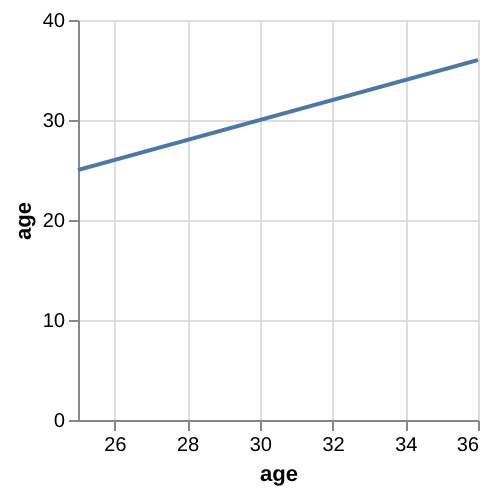

In [77]:
i = 1
a = df2["vega_dict"][i]

draw_vega(df2, index = i, scale = 2)

In [71]:
test = [1.0,1.0,0.91]
web = [1.0, 0.7]
plotqa = [0.96, 0.68]

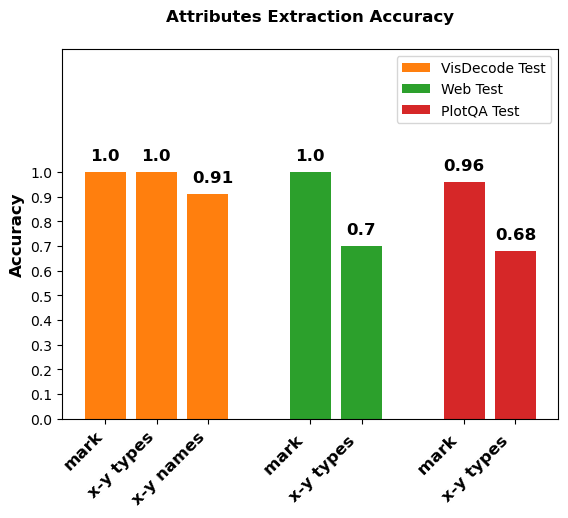

In [72]:
plt.title("Attributes Extraction Accuracy", pad = 20, fontweight = "bold")
plt.ylabel("Accuracy", fontweight = "bold", fontsize = 12)

plt.ylim(0,1.5)
plt.xticks([0,1,2,4,5,7,8], rotation = 45, ha = "right", fontsize = 12, fontweight = "bold")
plt.yticks(np.linspace(0,1,11))

plt.bar(["mark", "x-y types", "x-y names", "", "mark ", "x-y types ", " ", " mark ", " x-y types "], height = [0] * 9)

plt.bar([0,1,2], test, label = "VisDecode Test")
plt.bar([4,5], web, label = "Web Test")
plt.bar([7,8], plotqa, label = "PlotQA Test")

for i in range(3):
    plt.text(-0.3 + 1 * i, test[i] + 0.05, test[i], fontsize = 12, fontweight = "bold")

for i in range(2):
    plt.text(3.7 + 1 * i, web[i] + 0.05, web[i], fontsize = 12, fontweight = "bold")
    plt.text(6.6 + 1 * i, plotqa[i] + 0.05, plotqa[i], fontsize = 12, fontweight = "bold")
   
plt.legend()